# CITP一覧ページの分析
情報処理学会のCITP一覧ページ https://www.ipsj.or.jp/CITPholders.html の内容を分析、可視化する。

### 必要なライブラリのインポート

In [50]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import japanize_matplotlib
import re
import plotly.express as px

pd.set_option('display.max_rows', 100)

情報処理学会の一覧ベージからHTMLファイルを取得し、BeautifulSoupを用いて構文解析する。

In [51]:
r = requests.get(
    'https://www.ipsj.or.jp/CITPholders.html'
)
r.encoding = r.apparent_encoding
soup = BeautifulSoup(r.text, 'html.parser')

構文解析したHTMLの内容から、必要な情報を抜き出し、pandasのデータフレームに格納する。

In [52]:
df = pd.DataFrame( columns=["Number", "Company", "Name"] ) 
for i in soup.select("ul.citplist li"):
    tmp = i.get("title").split("/")
    number = tmp[1]
    company = tmp[0]
    df = df.append({"Number": number,"Company": company, "Name": i.text},ignore_index=True)

# 「氏名の公開を希望しない認定情報技術者の認定番号」以降の番号を取得する
only_number_div = soup.find('div', attrs={'style': 'width : 550px;'})

# 8桁の数字でできた文字列にマッチするパターン
pattern = re.compile('[0-9]{8}') 

for l in only_number_div.get_text().split("\r\n"):
    if pattern.match(l):
        # 会社名と氏名は空としてdfに追加しておく
        df = df.append({"Number": l, "Company": "", "Name": ""},ignore_index=True) 
df

,Number,Company,Name
0,18001016,（株）日立製作所,相澤 裕千
1,20000228,株式会社 日立製作所,相本 昌幸
2,17000582,ニッセイ情報テクノロジー株式会社,阿江 邦章
3,16001181,エヌ・ティ・ティ・コムウェア（株）,青井 智史
4,20000365,三菱電機インフォメーションシステムズ（株）,青井 晶哉
...,...,...,...
7293,20000221,,
7294,20000223,,
7295,20000255,,
7296,20000265,,


In [53]:
df[26:] # 原稿に使用するスクリーンショット用

,Number,Company,Name
26,15000004,（株）中電シーティーアイ,赤塚 正芳
27,18001325,エヌ・ティ・ティ・コムウェア（株）,赤沼 大我
28,14000022,"Konami Gaming, Inc.",赤根 大吾
29,20000230,株式会社日立製作所,秋田 美穂
30,16000924,エヌ・ティ・ティ・コムウェア（株）,秋間 利彦
...,...,...,...
7293,20000221,,
7294,20000223,,
7295,20000255,,
7296,20000265,,


Companyカラムにどのような項目が含まれているか、重複を除いて表示する。

In [54]:
set(df["Company"])

{'',
 '(株)日立製作所',
 '(株)日立製作所 社会ビジネスユニット 社会システム事業部 企画本部 企画部',
 'CCアーキテクト株式会社',
 'JCCソフト株式会社',
 'Konami Gaming, Inc.',
 'NECソリューションイノベータ株式会社',
 'NTTテクノクロス株式会社',
 'NTTテクノクロス（株）',
 'NTT西日本',
 'S&J（株）',
 'みずほ信託銀行',
 'みずほ情報総研 株式会社',
 'みずほ情報総研株式会社',
 'みずほ銀行',
 'アイテック阪急阪神株式会社',
 'アジア航測株式会社',
 'アルプスアルパイン株式会社',
 'インテグレーションテクノロジー株式会社',
 'イー・フォース株式会社',
 'エクセディア・コンサルティング株式会社',
 'エヌ・ティ・ティ・コムウェア株式会社',
 'エヌ・ティ・ティ・コムウェア（株）',
 'エリクソン・ジャパン株式会社',
 'コンピュートロン株式会社',
 'ソフトバンク・テクノロジー株式会社',
 'ソフトバンク（株）',
 'トヨタ自動車㈱',
 'ニッセイ情報テクノロジー株式会社',
 'ニッセイ情報テクノロジー（株）',
 'ハルコム',
 'リコーITソリューションズ株式会社',
 '㈱日立製作所',
 '三井物産セキュアディレクション株式会社',
 '三倉エンジニアリング株式会社',
 '三菱電機インフォメーションシステムズ（株）',
 '三菱電機インフォメーションシステム（株）',
 '三菱電機マイコン機器ソフトウエア株式会社',
 '三菱電機（株）',
 '京セラ株式会社',
 '力武健次技術士事務所',
 '吉川技術士事務所',
 '坂東技術士事務所',
 '大脇技術士事務所',
 '大阪府警察本部',
 '太平洋工業株式会社',
 '学校法人山脇学園',
 '富士通株式会社',
 '富士通（株）',
 '日本工営株式会社',
 '日本電技株式会社',
 '日本電気株式会社',
 '日本電気（株）',
 '日本ＮＣＲ株式会社',
 '日立製作所',
 '有限会社 Ovum Software',
 '東京ガスｉネット株式会社',
 '東芝インフラシステムズ株式会社',
 '東芝デジタルソリューションズ株式会社',
 '松下

会社名の表記を統一するための辞書を作成する。

In [55]:
replace_table = {
'': '非公開',
'(株)日立製作所': '日立製作所',
 '(株)日立製作所 社会ビジネスユニット 社会システム事業部 企画本部 企画部': '日立製作所',
 'CCアーキテクト株式会社': 'CCアーキテクト',
 'JCCソフト株式会社':  'JCCソフト',
 'NECソリューションイノベータ株式会社': 'NECソリューションイノベータ',
 'NTTテクノクロス株式会社': 'NTTテクノクロス',
 'NTTテクノクロス（株）':'NTTテクノクロス',
 'S&J（株）': 'S&J',
 'みずほ情報総研 株式会社': 'みずほ情報総研',
 'みずほ情報総研株式会社': 'みずほ情報総研',
 'アイテック阪急阪神株式会社': 'アイテック阪急阪神',
 'アジア航測株式会社': 'アジア航測',
 'アルプスアルパイン株式会社': 'アルプスアルパイン',
 'インテグレーションテクノロジー株式会社': 'インテグレーションテクノロジー',
 'イー・フォース株式会社': 'イー・フォース',
 'エクセディア・コンサルティング株式会社': 'エクセディア・コンサルティング',
 'エヌ・ティ・ティ・コムウェア株式会社': 'エヌ・ティ・ティ・コムウェア',
 'エヌ・ティ・ティ・コムウェア（株）': 'エヌ・ティ・ティ・コムウェア',
 'エリクソン・ジャパン株式会社': 'エリクソン・ジャパン',
 'コンピュートロン株式会社': 'コンピュートロン',
 'ソフトバンク・テクノロジー株式会社': 'ソフトバンク・テクノロジー',
 'ソフトバンク（株）': 'ソフトバンク',
 'トヨタ自動車㈱': 'トヨタ自動車',
 'ニッセイ情報テクノロジー株式会社': 'ニッセイ情報テクノロジー',
 'ニッセイ情報テクノロジー（株）': 'ニッセイ情報テクノロジー',
 'リコーITソリューションズ株式会社': 'リコーITソリューションズ',
 '㈱日立製作所': '日立製作所',
 '三井物産セキュアディレクション株式会社': '三井物産セキュアディレクション',
 '三倉エンジニアリング株式会社': '三倉エンジニアリング',
 '三菱電機インフォメーションシステムズ（株）': '三菱電機インフォメーションシステムズ',
 '三菱電機インフォメーションシステム（株）': '三菱電機インフォメーションシステムズ',
 '三菱電機マイコン機器ソフトウエア株式会社': '三菱電機マイコン機器ソフトウエア',
 '三菱電機（株）': '三菱電機',
 '京セラ株式会社': '京セラ',
 '太平洋工業株式会社': '太平洋工業',
 '学校法人山脇学園': '山脇学園',
 '富士通株式会社': '富士通',
 '富士通（株）': '富士通',
 '日本工営株式会社': '日本工営',
 '日本電技株式会社': '日本電技',
 '日本電気株式会社': 'NEC',
 '日本電気（株）': 'NEC',
 '日本ＮＣＲ株式会社': '日本ＮＣＲ',
 '有限会社 Ovum Software': 'Ovum Software',
 '東京ガスｉネット株式会社': '東京ガスｉネット',
 '東芝インフラシステムズ株式会社': '東芝インフラシステムズ',
 '東芝デジタルソリューションズ株式会社': '東芝デジタルソリューションズ',
 '株式会社 日立産機システム': '日立産機システム',
 '株式会社 日立製作所': '日立製作所',
 '株式会社SHIFT': 'SHIFT',
 '株式会社\u3000中電シーティーアイ': '中電シーティーアイ',
 '株式会社\u3000日立ソリューションズ・クリエイト': '日立ソリューションズ・クリエイト',
 '株式会社\u3000日立製作所': '日立製作所',
 '株式会社\u3000関電システムズ': '関電システムズ',
 '株式会社クリモトビジネスアソシエイツ': 'クリモトビジネスアソシエイツ',
 '株式会社スクウェア・エニックス': 'スクウェア・エニックス',
 '株式会社ソフトウェアコントロール': 'ソフトウェアコントロール',
 '株式会社タクマ': 'タクマ',
 '株式会社デンソー': 'デンソー',
 '株式会社ファースト': 'ファースト',
 '株式会社マクニカ': 'マクニカ',
 '株式会社リコー': 'リコー',
 '株式会社中電シーティーアイ': '中電シーティーアイ',
 '株式会社山下設計': '山下設計',
 '株式会社日立システムズ': '日立システムズ',
 '株式会社日立製作所': '日立製作所',
 '株式会社電通国際情報サービス': '電通国際情報サービス',
 '株式会社ＬＳＥＴ': 'ＬＳＥＴ',
 '沖電気工業株式会社': '沖電気工業',
 '独立行政法人\u3000国立高専機構\u3000東京工業高等専門学校': '東京工業高等専門学校',
 '（株）CIJ': 'CIJ',
 '（株）インテック': 'インテック',
 '（株）デジタルフィールド': 'デジタルフィールド',
 '（株）ハイマックス': 'ハイマックス',
 '（株）フィリップス・ジャパン': 'フィリップス・ジャパン',
 '（株）ラック': 'ラック',
 '（株）中電シーティーアイ': '中電シーティーアイ',
 '（株）日立制作所': '日立製作所',
 '（株）日立製作所': '日立製作所',
 '（株）日立製作所→退職個人へ': '個人',
 '（株）野村総合研究所': '野村総合研究所',
 'ＮＤＳ株式会社': 'ＮＤＳ',
}

上の辞書を用いてCompanyカラムの内容を置換し、再度内容を確認する。

In [56]:
df["Company"] = df["Company"].replace(replace_table)
set(df["Company"])

{'CCアーキテクト',
 'CIJ',
 'JCCソフト',
 'Konami Gaming, Inc.',
 'NEC',
 'NECソリューションイノベータ',
 'NTTテクノクロス',
 'NTT西日本',
 'Ovum Software',
 'S&J',
 'SHIFT',
 'みずほ信託銀行',
 'みずほ情報総研',
 'みずほ銀行',
 'アイテック阪急阪神',
 'アジア航測',
 'アルプスアルパイン',
 'インテグレーションテクノロジー',
 'インテック',
 'イー・フォース',
 'エクセディア・コンサルティング',
 'エヌ・ティ・ティ・コムウェア',
 'エリクソン・ジャパン',
 'クリモトビジネスアソシエイツ',
 'コンピュートロン',
 'スクウェア・エニックス',
 'ソフトウェアコントロール',
 'ソフトバンク',
 'ソフトバンク・テクノロジー',
 'タクマ',
 'デンソー',
 'トヨタ自動車',
 'ニッセイ情報テクノロジー',
 'ハイマックス',
 'ハルコム',
 'ファースト',
 'フィリップス・ジャパン',
 'マクニカ',
 'ラック',
 'リコー',
 'リコーITソリューションズ',
 '三井物産セキュアディレクション',
 '三倉エンジニアリング',
 '三菱電機',
 '三菱電機インフォメーションシステムズ',
 '三菱電機マイコン機器ソフトウエア',
 '中電シーティーアイ',
 '京セラ',
 '個人',
 '力武健次技術士事務所',
 '吉川技術士事務所',
 '坂東技術士事務所',
 '大脇技術士事務所',
 '大阪府警察本部',
 '太平洋工業',
 '富士通',
 '山下設計',
 '山脇学園',
 '日本工営',
 '日本電技',
 '日本ＮＣＲ',
 '日立システムズ',
 '日立ソリューションズ・クリエイト',
 '日立産機システム',
 '日立製作所',
 '東京ガスｉネット',
 '東京工業高等専門学校',
 '東芝インフラシステムズ',
 '東芝デジタルソリューションズ',
 '松下技術士事務所',
 '柏原コンサルティングオフィス',
 '沖電気工業',
 '石川Ｅ＆ＩＴ技術士事務所',
 '神戸学院大学',
 '野村総合研究所',
 '鍜治技術士事務所'

### 「認定情報技術者一覧」で公開されているCITPの情報は7298人分

In [57]:
len(df)

7298

### 7割にあたる約5000人は氏名や社名（所属）を公表していない

In [58]:
len(df.query('Name==""'))

5018

In [59]:
len(df.query('Company=="非公開"'))

5066

会社ごとのCITP所有者の数を集計し、上位20位を表示する。

In [60]:
df["Company"].value_counts().head(20).to_frame()

,Company
非公開,5066
エヌ・ティ・ティ・コムウェア,853
ニッセイ情報テクノロジー,445
日立製作所,389
三菱電機インフォメーションシステムズ,308
NTTテクノクロス,57
リコーITソリューションズ,53
中電シーティーアイ,19
みずほ情報総研,18
東芝インフラシステムズ,6


In [61]:
df["Company"].value_counts()

非公開                    5066
エヌ・ティ・ティ・コムウェア          853
ニッセイ情報テクノロジー            445
日立製作所                   389
三菱電機インフォメーションシステムズ      308
NTTテクノクロス                57
リコーITソリューションズ            53
中電シーティーアイ                19
みずほ情報総研                  18
東芝インフラシステムズ               6
富士通                       4
NEC                       3
リコー                       3
ラック                       2
インテック                     2
野村総合研究所                   2
日本工営                      2
デンソー                      1
ソフトウェアコントロール              1
三菱電機マイコン機器ソフトウエア          1
三倉エンジニアリング                1
クリモトビジネスアソシエイツ            1
鍜治技術士事務所                  1
みずほ銀行                     1
柏原コンサルティングオフィス            1
吉川技術士事務所                  1
力武健次技術士事務所                1
坂東技術士事務所                  1
NTT西日本                    1
Ovum Software             1
Konami Gaming, Inc.       1
山脇学園                      1
日本ＮＣＲ                     1
個人                        1
山下設計                      1
電設コンサルタンツ株式会社       

「非公開」ではなく、複数のCITPが存在する会社のCITPの数を棒グラフで表示。

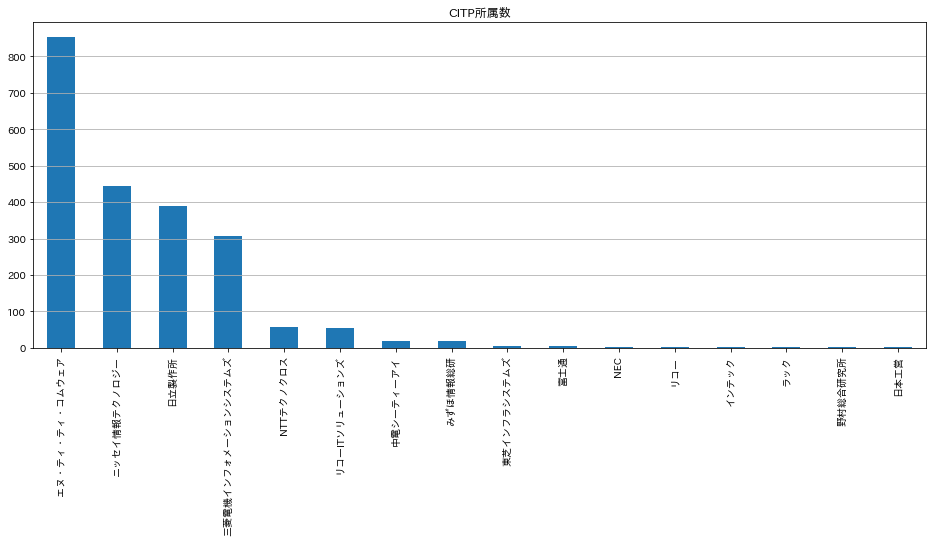

In [62]:
df_company_num = df.query(
    'Company != "非公開"'
)["Company"].value_counts()

fig = plt.figure(figsize=(16.0, 6.0))
ax = fig.add_subplot(111)
ax = df_company_num[df_company_num>1].plot(kind='bar')
ax.grid(axis="y")
plt.title("CITP所属数")
plt.show()


### これまででCITPがもっとも増加したのは2016年度、ついで2018年度。

In [63]:
def get_year_by_number(num):
    return 2000 + int(num[:2])

df["Year"] = df["Number"].apply(get_year_by_number)
df

,Number,Company,Name,Year
0,18001016,日立製作所,相澤 裕千,2018
1,20000228,日立製作所,相本 昌幸,2020
2,17000582,ニッセイ情報テクノロジー,阿江 邦章,2017
3,16001181,エヌ・ティ・ティ・コムウェア,青井 智史,2016
4,20000365,三菱電機インフォメーションシステムズ,青井 晶哉,2020
...,...,...,...,...
7293,20000221,非公開,,2020
7294,20000223,非公開,,2020
7295,20000255,非公開,,2020
7296,20000265,非公開,,2020


In [64]:
df["Year"].value_counts().sort_index()

2013       4
2014       9
2015     144
2016    3814
2017     544
2018    1972
2019     443
2020     368
Name: Year, dtype: int64

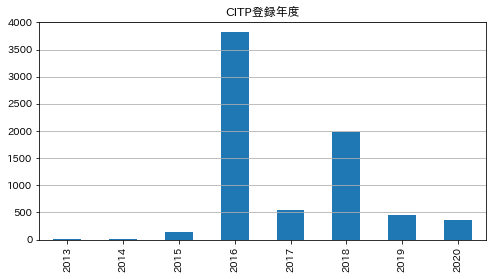

In [65]:
fig = plt.figure(figsize=(8.0, 4.0))
ax = fig.add_subplot(111)
ax = df["Year"].value_counts().plot(kind='bar')
ax.grid(axis="y")
plt.title("CITP登録年度")
plt.show()

### 内訳を見てみる

In [119]:
df.groupby(["Year", "Company"]).size()

Year  Company            
2013  フィリップス・ジャパン             1
      富士通                     1
      日立製作所                   2
2014  Konami Gaming, Inc.     1
      S&J                     1
                             ..
2020  中電シーティーアイ               1
      吉川技術士事務所                1
      日本電技                    1
      日立製作所                  66
      非公開                    34
Length: 118, dtype: int64

### Plotly.pyで使いやすいようにデータを加工
年と会社ごとに集計した結果をCountsというカラムの列にしてデータフレームに加工。

In [121]:
df_value_counts_by_year_company = df.groupby(["Year", "Company"]).size().to_frame(name="Counts")
df_value_counts_by_year_company

Counts
Year Company                    
2013 フィリップス・ジャパン               1
     富士通                       1
     日立製作所                     2
2014 Konami Gaming, Inc.       1
     S&J                       1
...                          ...
2020 中電シーティーアイ                 1
     吉川技術士事務所                  1
     日本電技                      1
     日立製作所                    66
     非公開                      34

[118 rows x 1 columns]

### 「整然データ」にする
各行に変数と観測値が含まれるように加工する。

In [122]:
df_for_plotly = df_value_counts_by_year_company.reset_index()
df_for_plotly

,Year,Company,Counts
0,2013,フィリップス・ジャパン,1
1,2013,富士通,1
2,2013,日立製作所,2
3,2014,"Konami Gaming, Inc.",1
4,2014,S&J,1
...,...,...,...
113,2020,中電シーティーアイ,1
114,2020,吉川技術士事務所,1
115,2020,日本電技,1
116,2020,日立製作所,66


In [116]:
fig = px.bar(
    df_for_plotly,
    x = "Year",
    y = "Counts",
    color = "Company",
)
fig.show()

### もっとも多くの組織からCITPが登録されたのは2019年度

In [70]:
size_company_year.groupby("Year").size()

Year
2013     3
2014     6
2015     6
2016     9
2017     8
2018     9
2019    61
2020    16
dtype: int64

### 中電シーティーアイは2014年以降、毎年CITPを輩出している

In [71]:
size_company_year.query('Company=="中電シーティーアイ"')[["Year","Count"]]

,Year,Count
7,2014,2
13,2015,2
21,2016,5
30,2017,5
36,2018,3
70,2019,1
113,2020,1


## このページの情報から読み取れる事

* このページで公開されているCITPの情報は7298人分。
* 7割にあたる約5000人は氏名や社名（所属）を公表していない
* もっとも多くのCITPを擁する組織は、エヌ・ティ・ティ・コムウェアの853人
* これまででCITPがもっとも増加したのは2016年度、ついで2018年度。
* もっとも多くの組織からCITPが登録されたのは2019年度
* 中電シーティーアイは2014年以降、毎年CITPを輩出している